In [1]:
import os

folder_path = "/cluster/home/austinen/mini/ampmini/data/esmfold_train_features"
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
print(f"Number of files: {file_count}")


Number of files: 21900


In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/new_AMP_sequences.csv")

# Replace 'your_column_name' with the actual column name
value_counts = df["id"].value_counts()

# Print result
print(value_counts)
print(f"Number of unique sequences: {len(value_counts)}")


FTRAMP00000002         1
NONFTRAMP00015188      1
NONFTRAMP00015198      1
NONFTRAMP00015196      1
NONFTRAMP00015195      1
                      ..
NONFTRAMP00005112      1
NONFTRAMP00005111      1
NONFTRAMP00005110      1
NONFTRAMP00005108      1
NONFTRAMP00010857X9    1
Name: id, Length: 21900, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x, context, context_mask=None):
        """
        x: (B, T_q, D) - query input
        context: (B, T_kv, D) - key/value input
        context_mask: (B, T_kv) - optional attention mask for context
        """
        # Cross-attention
        attn_out, _ = self.cross_attn(query=x, key=context, value=context, key_padding_mask=context_mask)
        x = x + attn_out
        x = self.norm1(x)

        # Feed-forward
        mlp_out = self.mlp(x)
        x = x + mlp_out
        x = self.norm2(x)

        return x

class TranCNN(nn.Module):

    def __init__(
        self, 
        d_input=[531,21,23,3],
        vocab_size=None, 
        seq_len=200,
        dropout=0.1,
        hid_dim=64,
        k_cnn=[2,3,4,5,6],
        d_output=24,
        k_size=2,
        depth = 4):
        super(TranCNN, self).__init__()
        
        self.batchnorm_4=nn.BatchNorm1d(num_features=d_input[3])
        self.convs_1 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[0], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_2 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[1], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_3 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[2], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        self.convs_4 = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=d_input[3], 
                                        out_channels=hid_dim, 
                                        kernel_size=h,padding = h//2),
                              nn.BatchNorm1d(num_features=hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k_size))
                     for h in k_cnn
                    ])
        
        self.maxpool_1=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_2=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_3=nn.MaxPool1d(kernel_size=len(k_cnn))
        self.maxpool_4=nn.MaxPool1d(kernel_size=len(k_cnn))

        self.conv = nn.Sequential(nn.Conv1d(in_channels=4*hid_dim, 
                                        out_channels=8*hid_dim, 
                                        kernel_size=3, 
                                        padding=1),
                                        nn.BatchNorm1d(num_features=8*hid_dim),
                                        nn.ReLU(),
                                        nn.MaxPool1d(kernel_size=2))
        
        self.middle = nn.ModuleList([MBlock(8*hid_dim, 8, mlp_ratio=3.0, dropout=dropout) for _ in range(depth)])
        self.drop = nn.Dropout(dropout)
        self.final = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=8*hid_dim, 
                                        out_channels=8*hid_dim, 
                                        kernel_size=3,padding = k//2),
                              nn.BatchNorm1d(num_features=8*hid_dim), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=k))
                     for k in [5,5,2]
                    ])
        
        self.fc = nn.Linear(8*hid_dim, d_output)
        self.sigmoid=nn.Sigmoid()



    def forward(self, AAI_feat,onehot_feat,BLOSUM62_feat,PAAC_feat):
        
        AAI_feat = AAI_feat.permute(0,2,1)
        out_1 = [conv(AAI_feat) for conv in self.convs_1] 
        onehot_feat = onehot_feat.permute(0,2,1)
        out_2 = [conv(onehot_feat) for conv in self.convs_2] 
        BLOSUM62_feat = BLOSUM62_feat.permute(0,2,1)
        out_3 = [conv(BLOSUM62_feat) for conv in self.convs_3] 
        PAAC_feat = PAAC_feat.permute(0,2,1)
        out_4 = [conv(PAAC_feat) for conv in self.convs_4] 
        

        out_1 = torch.cat(out_1, dim=2)
        out_1=self.maxpool_1(out_1)
        out_2 = torch.cat(out_2, dim=2)
        out_2=self.maxpool_2(out_2)
        out_3 = torch.cat(out_3, dim=2)
        out_3=self.maxpool_3(out_3)
        out_4 = torch.cat(out_4, dim=2)
        out_4=self.maxpool_4(out_4)
    
        x=torch.cat([out_1,out_2,out_3,out_4],dim=1)
        x = self.conv(x)
        x = x.permute(0,2,1)
        for mlayer in self.middle:
            x = mlayer(x, x)
        x = x.permute(0,2,1)
        for layer in self.final:
            x = layer(x)
        x = x.view(-1, x.size(1)) 
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
# Example usage
AAI_feat = torch.randn(2, 200, 531)
onehot_feat = torch.randn(2, 200, 21)
BLOSUM62_feat = torch.randn(2, 200, 23)
PAAC_feat = torch.randn(2, 200, 3)
model = TranCNN()
output = model(AAI_feat, onehot_feat, BLOSUM62_feat, PAAC_feat)
print(output.shape) 


torch.Size([2, 1])


In [ ]:
# python3 run_pretrained_openfold.py \
#     /cluster/home/austinen/mini/openfold/examples/monomer/fasta_dir \
#     /cluster/home/austinen/mini/database/ \
#     --output_dir /cluster/home/austinen/mini/openfold/examples/output \
#     --config_preset model_1_ptm \
#     --uniref90_database_path $BASE_DATA_DIR/uniref90 \
#     --mgnify_database_path $BASE_DATA_DIR/mgnify/mgy_clusters_2018_12.fa \
#     --pdb70_database_path $BASE_DATA_DIR/pdb70 \
#     --uniclust30_database_path $BASE_DATA_DIR/uniclust30/uniclust30_2018_08/uniclust30_2018_08 \
#     --bfd_database_path $BASE_DATA_DIR/bfd/bfd_metaclust_clu_complete_id30_c90_final_seq.sorted_opt \
#     --model_device "cuda:0"

# python run_pretrained_openfold.py \
#     /cluster/home/austinen/mini/openfold/examples/monomer/fasta_dir \ 
#     /cluster/home/austinen/mini/database/ \
#     --output_dir ./ \
#     --model_device "cuda:0" \
#     --use_single_seq_mode \
#     --config_preset "seq_model_esm1b_ptm" \
#     --openfold_checkpoint_path openfold/resources/openfold_soloseq_params/seq_model_esm1b_ptm.pt

SyntaxError: invalid syntax (2067346625.py, line 13)

In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_path)

# Drop the 'id' and 'sequence' columns as we only need the activity columns
activity_columns = df.columns[2:]  # Assuming 'id' and 'sequence' are the first two columns

# Create a dictionary to store the count of sequences with specific number of 1's
count_dict = {i: 0 for i in range(len(activity_columns) + 1)}  # max number of 1's is the number of activity columns

# Create a dictionary to store the count of 1's in each activity column
activity_counts = {col: 0 for col in activity_columns}

# Iterate over each row in the DataFrame and count the 1's in the activity columns
for index, row in df.iterrows():
    # Count the number of 1's in the activity columns
    num_ones = row[activity_columns].sum()
    
    # Increment the count for this number of 1's
    count_dict[num_ones] += 1

    # Count the number of 1's in each activity column
    for col in activity_columns:
        activity_counts[col] += row[col]

# Print the counts of sequences with each number of 1's
print("Count of sequences with specific numbers of 1's:")
for num_ones, count in count_dict.items():
    print(f"Sequences with {num_ones} ones: {count}")

# Print the number of 1's in each individual activity column
print("\nCount of 1's in each activity column:")
for col, count in activity_counts.items():
    print(f"{col}: {count}")



Count of sequences with specific numbers of 1's:
Sequences with 0 ones: 6195
Sequences with 1 ones: 8511
Sequences with 2 ones: 1939
Sequences with 3 ones: 1619
Sequences with 4 ones: 1421
Sequences with 5 ones: 824
Sequences with 6 ones: 610
Sequences with 7 ones: 381
Sequences with 8 ones: 261
Sequences with 9 ones: 146
Sequences with 10 ones: 71
Sequences with 11 ones: 26
Sequences with 12 ones: 15
Sequences with 13 ones: 7
Sequences with 14 ones: 1
Sequences with 15 ones: 1
Sequences with 16 ones: 1
Sequences with 17 ones: 0
Sequences with 18 ones: 0
Sequences with 19 ones: 0
Sequences with 20 ones: 0
Sequences with 21 ones: 0
Sequences with 22 ones: 0
Sequences with 23 ones: 0
Sequences with 24 ones: 0

Count of 1's in each activity column:
antibacterial: 8865
antigram-positive: 5101
antigram-negative: 5346
antifungal: 3926
antiviral: 3525
anti_mammalian_cells: 2812
antihiv: 509
antibiofilm: 242
anticancer: 3262
antimrsa: 202
antiparasitic: 313
hemolytic: 1643
chemotactic: 66
anti

In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences.csv'
df = pd.read_csv(csv_path)

# Drop the 'id' and 'sequence' columns to isolate activity columns
activity_columns = df.columns[2:]

# Calculate number of ones per row
df['num_ones'] = df[activity_columns].sum(axis=1)

# Filter out sequences with zero ones
filtered_df = df[df['num_ones'] > 0].drop(columns='num_ones')

# Save to new CSV
output_path = '/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv'
filtered_df.to_csv(output_path, index=False)

print(f"Filtered dataset saved to: {output_path}")
print(f"Original dataset size: {len(df)}, Filtered size: {len(filtered_df)}")


Filtered dataset saved to: /cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv
Original dataset size: 22029, Filtered size: 15834


In [16]:
from transformers import AutoTokenizer, EsmForProteinFolding

model = EsmForProteinFolding.from_pretrained("./esmfold_v1_local",local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("./esmfold_v1_local",local_files_only=True)
inputs = tokenizer(["MLKNVQVQLV","MLKNVQVQLV","MLKNVQVQLV","MLKNVQVQLV",], return_tensors="pt", add_special_tokens=False)  # A tiny random peptide
outputs = model(**inputs)
folded_positions = outputs.states
print(folded_positions.shape)
print(outputs.s_s.shape)
print(outputs.s_z.shape)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
import torch
from transformers import AutoTokenizer, EsmForProteinFolding

# Load model and tokenizer from local directory
model = EsmForProteinFolding.from_pretrained("./esmfold_v1_local", local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("./esmfold_v1_local", local_files_only=True)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Turn off dropout

# Prepare input sequences
sequences = ["MLKNVQVQLV"] * 4  # Batch of 4 sequences

# Tokenize and move inputs to GPU
inputs = tokenizer(sequences, return_tensors="pt", add_special_tokens=False)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model inference
with torch.no_grad():
    outputs = model(**inputs)

# Access outputs
folded_positions = outputs.states  # (B, L, D)
print("folded_positions:", folded_positions.shape)
print("s_s (per-residue embedding):", outputs.s_s.shape)   # (B, L, D)
print("s_z (pairwise features):", outputs.s_z.shape)       # (B, L, L, D)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

folded_positions: torch.Size([8, 4, 10, 384])
s_s (per-residue embedding): torch.Size([4, 10, 1024])
s_z (pairwise features): torch.Size([4, 10, 10, 128])


In [13]:
from transformers import AutoTokenizer, EsmForProteinFolding

model_name = "facebook/esmfold_v1"

# Download from Hugging Face and cache locally
model = EsmForProteinFolding.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Save locally to a directory
model.save_pretrained("./esmfold_v1_local")
tokenizer.save_pretrained("./esmfold_v1_local")


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('./esmfold_v1_local/tokenizer_config.json',
 './esmfold_v1_local/special_tokens_map.json',
 './esmfold_v1_local/vocab.txt',
 './esmfold_v1_local/added_tokens.json')

In [7]:
from transformers import AutoTokenizer, EsmForProteinFolding
import torch

# Load the model and tokenizer
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

# Example protein sequence (single chain protein)
sequence = "GSTIQPGTGYNNGYFYSYWNDGHGGVTYTNGPGGQF"

# Tokenize the input sequence
inputs = tokenizer(sequence, return_tensors="pt")

# Define the number of recycles for inference (higher values yield better accuracy)
num_recycles = 4

# Run the model for structure prediction
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"], 
        num_recycles=num_recycles,
    )

# Get the hidden states (feature maps) from the model
hidden_states = outputs.hidden_states  # This will be a tuple containing hidden states from each layer

# Extract the feature maps from the last hidden layer (or any intermediate layer)
# For example, using the last hidden state layer
last_hidden_states = hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

# Example: You can also use intermediate hidden states, e.g., the 12th layer in ESM-2 model
intermediate_hidden_states = hidden_states[12]  # For example, using the 12th layer

# Now `last_hidden_states` or `intermediate_hidden_states` can be used as feature maps
# These feature maps can be used for cross-attention or any downstream tasks

# Example: Print the shape of the last hidden states
print("Shape of last hidden states (feature maps):", last_hidden_states.shape)  # (batch_size, sequence_length, hidden_size)

# Example: Print the feature map from the first token (representing the start of the sequence)
print("Feature map for the first token:", last_hidden_states[0, 0].tolist())  # The feature map for the first token


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IndexError: index 24 is out of bounds for dimension 0 with size 22

In [ ]:
import pandas as pd
from collections import Counter
from itertools import accumulate

# Load the CSV file
df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv")

# Compute sequence lengths
lengths = df["sequence"].dropna().apply(len)

# Count occurrences of each length
length_counts = Counter(lengths)

# Sort by length
length_counts = dict(sorted(length_counts.items()))

# Compute cumulative counts
cumulative_counts = list(accumulate(length_counts.values()))

# Print results
for (length, count), cum_count in zip(length_counts.items(), cumulative_counts):
    print(f"Length {length}: {count} sequences (Cumulative: {cum_count})")


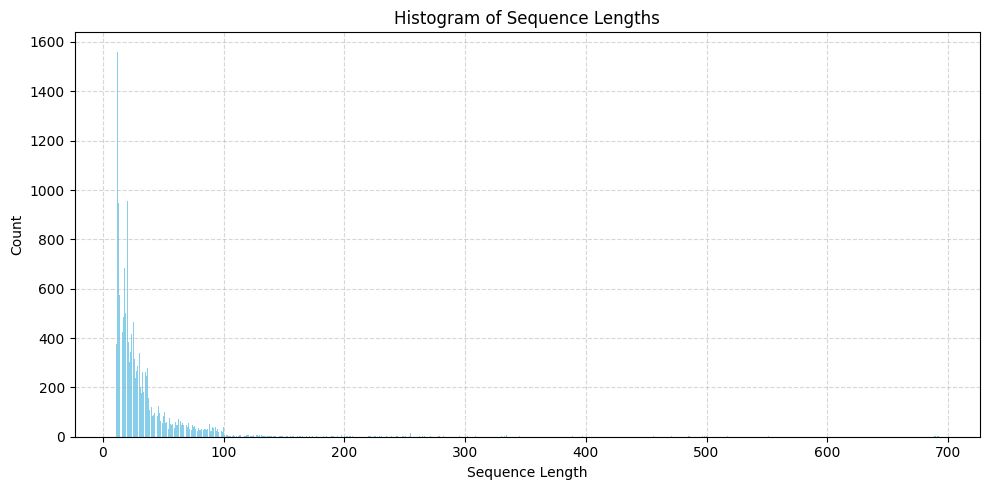

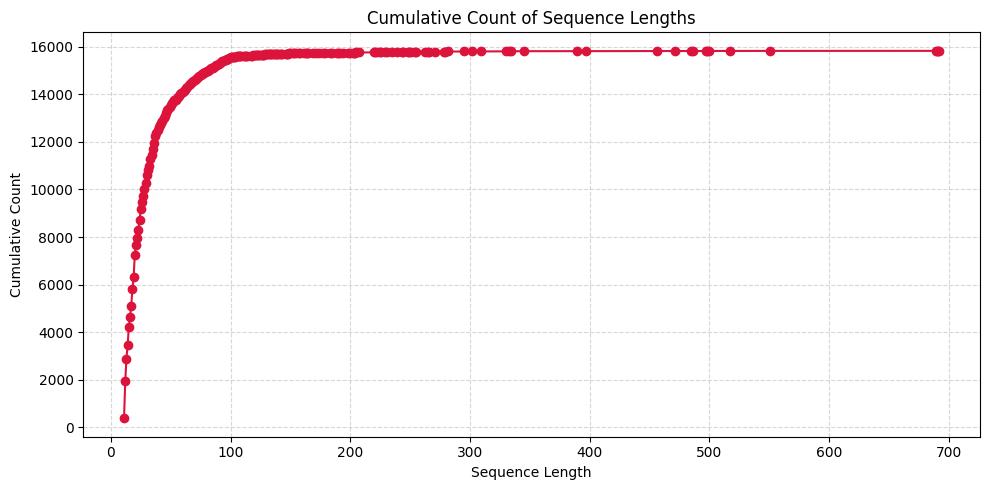


Mean of counts: 76.49
Variance of counts: 33819.85


In [4]:
import pandas as pd
from collections import Counter
from itertools import accumulate
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv("/cluster/home/austinen/mini/ampmini/data/AMP_sequences_filtered.csv")

# Compute sequence lengths
lengths = df["sequence"].dropna().apply(len)

# Count occurrences of each length
length_counts = Counter(lengths)

# Sort by length
length_counts = dict(sorted(length_counts.items()))

# Compute cumulative counts
cumulative_counts = list(accumulate(length_counts.values()))

# Print results
# for (length, count), cum_count in zip(length_counts.items(), cumulative_counts):
#     print(f"Length {length}: {count} sequences (Cumulative: {cum_count})")

# Prepare data for plotting
length_keys = list(length_counts.keys())
counts = list(length_counts.values())

# Plot histogram (bar plot)
plt.figure(figsize=(10, 5))
plt.bar(length_keys, counts, color='skyblue')
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Histogram of Sequence Lengths")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot cumulative count (line plot)
plt.figure(figsize=(10, 5))
plt.plot(length_keys, cumulative_counts, color='crimson', marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Count of Sequence Lengths")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Compute statistics
mean_count = np.mean(counts)
var_count = np.var(counts)

print(f"\nMean of counts: {mean_count:.2f}")
print(f"Variance of counts: {var_count:.2f}")
